# Подготовка датасета, подготовка видео и обучение нейросети

# Предварительно была выполнена аналитика датасета и выделено несколько ключевых закономерностей/инсайтов о датасете:

1. Минимальная длина заставки к видео 5-10 секунд и на протяжении всего этого времени - каждый кадр в видео является заставкой.
2. Кадры заставки идут подряд, кадры не заставки тоже идут подряд
3. Всего в датасете 2 возможных значения fps - 24 или 25.
4. Два видео с длиной заставки в ~60 и ~80 секунд будут являться выбросами.
5. Минимальная ширина видео - 480 пикселей, а минимальная высота - 360 пикселей, то есть размер видео можно унифицировать сжатием до меньших значений (downscaling).
6. Зависимости времени заставки от времени начала заставки или времени окончания заставки выделить не удалось, поэтому потребуется более хитрый алгоритм.

# Моя стратегия работы по обучению нейросети:

1. Универсального подхода по работе с видео на данный момент не существует, большинство доступных решений (kaggle, hugging face) - это работа с изображениями или работа с видео но покадрово, то необходимо придумать свой способ реализации задачи поиска времени начала и окончания заставки.
2. Видео в общем смысле состоит из 3х составляющих - кадры, временное распределение кадров, звук. Для полноценного решения задачи определения времени заставки необходимо использовать все 3 данных параметра.
3. Из рассмотренных вариантов, изученных открытых решений и опыта решения задач связанных с видео можно рассмотреть несколько подходов:
- Первый вариант - рассмотреть видео - как 3д матрицу, в общем случае 4д матрицу (терзор) - 1 ось - цветовые каналы, 2 оси ширина и высота кадра, 1 ось - набор кадров. Тогда после использовании 4д свертки можно получить 3х мерное изображение, с которым уже можно работать далее при помощи нейросети, но есть несколько ограничений: сложность написания такой сети в короткие сроки и малый размер датасета - всего 125 (123 после удаления выбросов) видео, по такому количеству элементов для обучения сложно получить хороший результат
-  Второй вариант (основа моей стратегии) - это разметить датасет покадрово на 2 класса - кадр заставки/кадр не заставки и решать задачу бинарной классификации кадров. Так как подходящих кадров в каждом видео будет в среднем mean(время заставки) * mean(fps) * 85 = 26.5 тыс кадров заставок + столько же кадров не заставок добавить, в итоге получится 53 тыс картинок (кадров) если сбалансировать классы, или даже более если сделать классы несбалансироваными, что является достаточным для обучения нейросети датасетом. Использовать я планирую нейросеть YOLOv11cls, предобученной версии, поэтому на выходе можно получать вероятность принадлежности кадра к заставке. После того, как такая нейросеть пройдется по всем кадрам видео будет участок видео, где кадры идущие подряд принадлежат классу заставка, значит заставка будет идти именно в этом месте. Следовательно можно получить конкретный номер кадра - когда начинается и заканчивается заставка, а значит и конкретные временные метки.
-  Третий подход - это файнтюнинг второго подхода и мультимодальная стратегия - например вместо одного из цветового канала картинки можно вставить фильтр Cобеля, так как в заставке присутствует контрастный текст, что позволит модели выделять такие кадры и к получившемуся результату добавить вторую нейросеть, которая будет анализировать только звуковой канал и выдавать метки времени начала и конца заставки исходя из звука, потом после усреднения результата звуковой модели и модели картиночной (с некоторыми весовыми коэффициентами) можно будет получить результат.

4. Базово мною будет выполнен второй вариант, в дальнейшем к нему можно будет добавить 3й вариант.

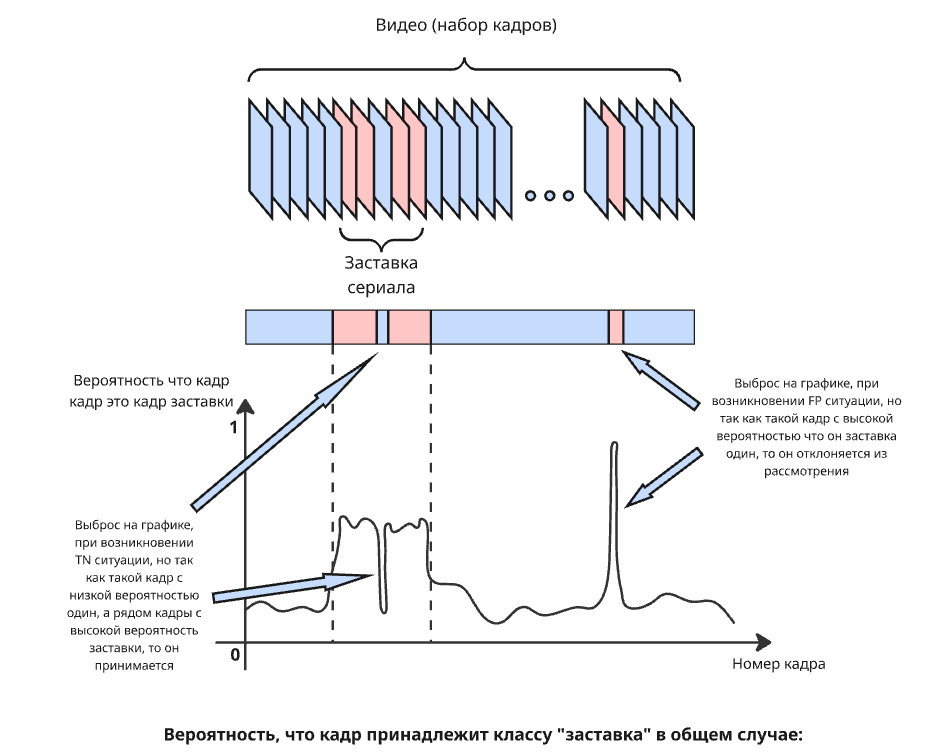
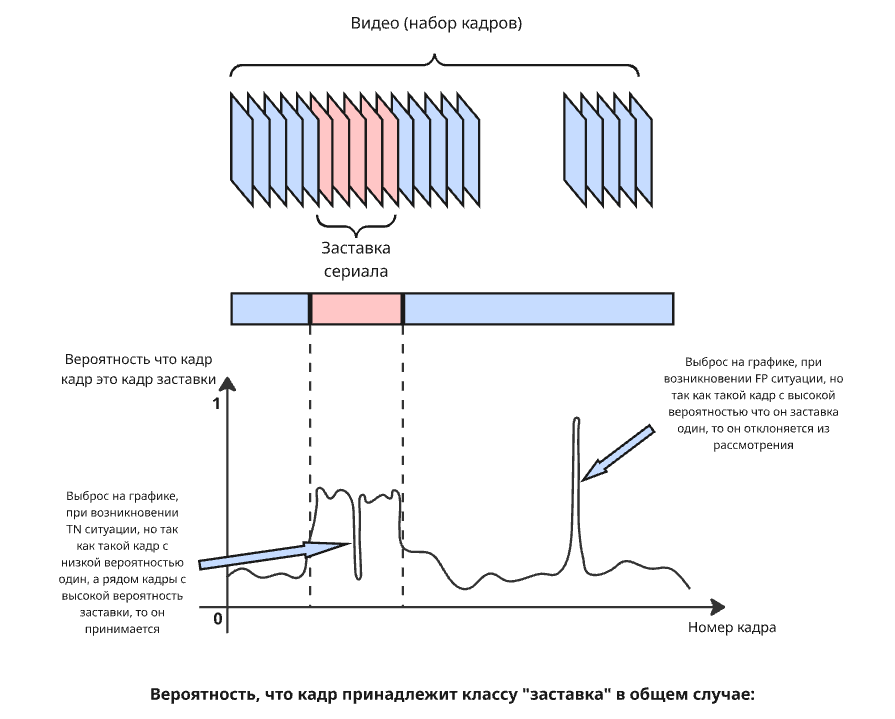

# Ниже представлен пайплайн исследования и обучения модели нейронной сети для решения задачи бинарной классификации кадров из видео на 2 класса - заставка/не заставка

In [1]:
# Установка библиотеки с моделью YOLO
!pip install ultralytics==8.3.156

In [2]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd
import os
import json
from datetime import datetime, timedelta
import cv2
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO

# Подготовим и разметим датасет

1) Спарсим информацию о видео из json, правильно данную информацию обработаем (как это делали в аналитике) и создадим единый словарь с информацией {id video: [время начала заставки, время окончания заставки]}

In [3]:
project_dir = '/kaggle/input/vk-series-data/'
test_target = os.path.join(project_dir, 'test_labels.json')
train_target = os.path.join(project_dir, 'train_labels.json')

with open(test_target) as f:
    test_target_dict = json.load(f)

with open(train_target) as f:
    train_target_dict = json.load(f)

np_labels = {}

def process_bad_times(dictionary):

    for name, description in dictionary.items():
        start_time = datetime.strptime(description["start"], "%H:%M:%S")
        end_time = datetime.strptime(description["end"], "%H:%M:%S")
        if start_time > end_time:
            start_time = start_time - timedelta(minutes=1)
            description["start"] = start_time.strftime("%H:%M:%S")

        np_labels[name] = [description["start"], description["end"]]

process_bad_times(train_target_dict)
process_bad_times(test_target_dict)

# Не было вычислено при анализе из-за метода записи и конкатенации датафреймов, и определилось только сейчас, но у нас всего 110 уникальных записей (уникальных видео), записи меток у таких видео идентичны, следовательно разделение test/val/train будет выполнено в соотношении 10/15/85.

2. Всю выборку - 110 видео разделим на test/val/train в соотношении 10/15/85. Обработаем видео, и загрузим в kaggle/output ("kaggle/working/data") со сбалансированными классами заставка/не заставка - 1/0. Так как при обучении модели придется много раз перезапускать блокнот, а при перезапуске все видео будут парситься заново, то я решил задачу создания датасета упростить. Кодом ниже был обработан, упрощен, размечен и разбит датасет и загружен в output. Далее я даатсет (~200 Мб) Загрузил локально на компьютер, а затем и в датасем kaggle input рядом с файлами видео. Теперь данные будут каждый раз подгружаться оттуда, что упростит работу блокнота и избавит от необходимости заново создавать датасет. Путем тестов было определено, что блокнот каггл не перегружается, его он обрабатывает каждый 4й кадр в видео, поэтому датасет стал меньше в 4 раза и большое количество кадров не использовалось так как кадров с меткой заставка должно быть столько же, сколько и кадров не заставка. Итоговый датасет - 16384 картики. 8192 - класса заставка, 8192 - класса не заставка.

In [4]:
# Соберу пути до всех файлов в один массив

project_dir = '/kaggle/input/vk-series-data/'
test_path = os.path.join(project_dir, 'data_test_short/data_test_short/')
train_path = os.path.join(project_dir, 'data_train_short/data_train_short/')

paths = []

def scan_paths(root_paths):
    seen = set()
    paths = []
    for root in root_paths:
        for entry in os.scandir(root):
            if entry.is_dir():
                for fn in os.listdir(entry.path):
                    full = os.path.join(entry.path, fn)
                    video_id = os.path.splitext(fn)[0]
                    if video_id not in seen and fn.lower().endswith(('.mp4', '.avi', '.mov')):
                        seen.add(video_id)
                        paths.append(full)
    return paths

all_paths = scan_paths([test_path, train_path])

In [5]:
import shutil

working_dir = '/kaggle/working'

# Удаляем все файлы и папки внутри /kaggle/working перед загрузкой данных
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)

print(f"Все содержимое папки {working_dir} удалено")

Все содержимое папки /kaggle/working удалено


3. При необходимости проверить создание файлов, раскомментируйте ячейку

In [6]:
# import yaml
# from tqdm import tqdm

# project_dir = '/kaggle/working/'
# train_root  = os.path.join(project_dir, 'data_train_short/data_train_short/')
# test_root   = os.path.join(project_dir, 'data_test_short/data_test_short/')

# intro_times = np_labels

# # Вспомогательная функция перевода времени
# def parse_time(t: str) -> float:
#     parts = [float(x) for x in t.split(':')]
#     if len(parts)==3:
#         return parts[0]*3600 + parts[1]*60 + parts[2]
#     if len(parts)==2:
#         return parts[0]*60 + parts[1]
#     return parts[0]

# # train_test_split, но вручную
# all_ids = [os.path.splitext(os.path.basename(p))[0] for p in all_paths]
# random.seed(42)
# random.shuffle(all_ids)
# test_ids  = set(all_ids[:10])
# val_ids   = set(all_ids[10:25])
# train_ids = set(all_ids[25:])

# # Подготовка папок
# data_dir = os.path.join(project_dir, 'data')
# for split in ('train','val','test'):
#     os.makedirs(os.path.join(data_dir, split, 'images'), exist_ok=True)
#     os.makedirs(os.path.join(data_dir, split, 'labels'), exist_ok=True)

# # Цикл обработки кадров и созранения результата в kaggle/working/
# # Сохраняем каждый 4-й кадр, сначала все с label=1, затем столько же с label=0
# for video_path in tqdm(all_paths, desc="Обработка видео", unit="файл"):
#     vid = os.path.splitext(os.path.basename(video_path))[0]
#     if vid in train_ids:
#         split = 'train'
#     elif vid in val_ids:
#         split = 'val'
#     elif vid in test_ids:
#         split = 'test'
#     else:
#         continue

#     times = intro_times.get(vid)
#     if times is None:
#         continue
#     t0 = parse_time(times[0])
#     t1 = parse_time(times[1])

#     cap = cv2.VideoCapture(video_path)
#     real_fps = cap.get(cv2.CAP_PROP_FPS)
#     # определяем шаг: берем каждый 4-й кадр
#     step = 4
#     frame_idx = 0

#     pos_frames = []
#     neg_frames = []
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
#         if frame_idx % step == 0:
#             time_sec = frame_idx / real_fps
#             label = 1 if (t0 <= time_sec <= t1) else 0
#             if label == 1:
#                 pos_frames.append(frame)
#             else:
#                 neg_frames.append(frame)
#         frame_idx += 1
#     cap.release()

#     # балансировка: сохраняем все pos, и ровно столько neg
#     n_pos = len(pos_frames)
#     neg_sample = random.sample(neg_frames, min(len(neg_frames), n_pos))

#     # сохраняем кадры
#     cnt = 0
#     for idx, frame in enumerate(pos_frames + neg_sample):
#         img = cv2.resize(frame, (224,224), interpolation=cv2.INTER_AREA)
#         fn = f"{vid}_{cnt:04d}.jpg"
#         cv2.imwrite(os.path.join(data_dir, split, 'images', fn), img)
#         # сохраняем label
#         lbl = 1 if idx < n_pos else 0
#         with open(os.path.join(data_dir, split, 'labels', fn.replace('.jpg','.txt')), 'w') as f:
#             f.write(str(lbl))
#         cnt += 1

# # data.yaml необходим для модели YOLO
# cfg = {
#     'path': 'data',
#     'train': 'train/images',
#     'val':   'val/images',
#     'test':  'test/images',
#     'nc': 2,
#     'names': ['no_intro', 'intro']
# }
# with open(os.path.join(project_dir,'data','data.yaml'), 'w') as f:
#     yaml.dump(cfg, f)

In [7]:
# # Создаю .zip архив для выгрузки данных, для проверки - раскомментируйте
# input_dir = '/kaggle/working/data'
# output_zip = '/kaggle/working/data.zip'

# shutil.make_archive('/kaggle/working/data', 'zip', input_dir)

# print(f"Zip archive created at {output_zip}")

# Теперь загрузку данных в модель можно организовать через kaggle input из ранее подготовленной папки prepared_data, загрузим датасет в kaggle output, и начнем обучение модели.

In [8]:
# Копирование в kaggle output

src_dir = '/kaggle/input/vk-series-data/prepared_data'
dst_base = '/kaggle/working/data'

# 2) Копируем всю предобработанную структуру в рабочую директорию
if os.path.exists(dst_base):
    shutil.rmtree(dst_base)
shutil.copytree(src_dir, dst_base)

# 3) Создаём структуру папок для классификации
for split in ('train', 'val', 'test'):
    for cls in ('0', '1'):
        os.makedirs(os.path.join(dst_base, split, cls), exist_ok=True)

# 4) Перемещаем файлы по классам
for split in ('train', 'val', 'test'):
    img_dir = os.path.join(dst_base, split, 'images')
    lbl_dir = os.path.join(dst_base, split, 'labels')
    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        label_file = img_name.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(lbl_dir, label_file)
        if not os.path.isfile(label_path):
            continue
        with open(label_path, 'r') as f:
            lbl = f.read().strip()  # '0' или '1'
        src_img = os.path.join(img_dir, img_name)
        dst_img = os.path.join(dst_base, split, lbl, img_name)
        shutil.move(src_img, dst_img)

# 5) Удаляем старые папки images/ и labels/
for split in ('train', 'val', 'test'):
    shutil.rmtree(os.path.join(dst_base, split, 'images'))
    shutil.rmtree(os.path.join(dst_base, split, 'labels'))

In [9]:
model = YOLO("yolo11n-cls.pt")

100%|██████████| 5.52M/5.52M [00:00<00:00, 74.9MB/s]


# Выбрал 12 для обучения так как далее модель начинала переобучаться, а также добавил слои dropout для улучшения обощающей способности

In [10]:
results = model.train(
    task='classify',
    data="/kaggle/working/data/",
    epochs=22,
    imgsz=224,
    project='/kaggle/working/results',
    batch=8,
    dropout=0.5,
)

Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data/, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.5, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 311.5±104.4 MB/s, size: 10.0 KB)


train: Scanning /kaggle/working/data/train... 12544 images, 0 corrupt: 100%|██████████| 12544/12544 [00:04<00:00, 2896.48it/s]


train: New cache created: /kaggle/working/data/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 216.3±147.4 MB/s, size: 13.6 KB)


val: Scanning /kaggle/working/data/val... 2590 images, 0 corrupt: 100%|██████████| 2590/2590 [00:00<00:00, 2834.33it/s]


val: New cache created: /kaggle/working/data/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to /kaggle/working/results/train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 25.38it/s]

                   all      0.891          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 26.63it/s]

                   all      0.898          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 25.93it/s]

                   all      0.871          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 26.79it/s]

                   all      0.894          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 26.46it/s]

                   all      0.883          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 26.39it/s]

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 25.67it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 25.32it/s]

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 24.50it/s]

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.338G     0.2409         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 22.79it/s]

                   all      0.912          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.346G     0.2304         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.11it/s]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.355G     0.2131         16        224: 100%|██████████| 784/784 [00:51<00:00, 15.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 24.30it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.363G     0.2171         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.40it/s]

                   all      0.911          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.371G     0.2034         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.42it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.381G     0.1784         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 22.76it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.389G     0.1744         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.30it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.398G     0.1641         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 22.74it/s]

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.406G     0.1564         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 22.86it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.416G     0.1517         16        224: 100%|██████████| 784/784 [00:45<00:00, 17.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.96it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.424G      0.139         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.82it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.434G     0.1319         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.21it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.441G     0.1226         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.66it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.451G     0.1151         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.10it/s]


                   all      0.924          1

      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.459G     0.1097         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.82it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.469G     0.1081         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 24.08it/s]

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.477G     0.1007         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.46it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.484G    0.09381         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.81it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.494G    0.08921         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.69it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.502G    0.07912         16        224: 100%|██████████| 784/784 [00:49<00:00, 15.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 21.66it/s]

                   all      0.922          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.512G    0.07876         16        224: 100%|██████████| 784/784 [00:50<00:00, 15.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.62it/s]

                   all      0.924          1



30 epochs completed in 0.441 hours.
Optimizer stripped from /kaggle/working/results/train/weights/last.pt, 3.2MB
Optimizer stripped from /kaggle/working/results/train/weights/best.pt, 3.2MB

Validating /kaggle/working/results/train/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /kaggle/working/data/train... found 12544 images in 2 classes ✅ 
val: /kaggle/working/data/val... found 2590 images in 2 classes ✅ 
test: /kaggle/working/data/test... found 1250 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 81/81 [00:03<00:00, 23.48it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.942          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/results/train


# Сохраним модель

In [11]:
import datetime

today = datetime.datetime.today().strftime('%Y-%m-%d')

model_filename = f"yolo_model_{today}.pt"
model_path = os.path.join("/kaggle/working", model_filename)
model.save(model_path)

os.listdir('/kaggle/working/')

['data', 'yolo_model_2025-06-17.pt', 'results', 'yolo11n-cls.pt', 'yolo11n.pt']

# Загружаем данные из csv в датафрейм

In [13]:
csv_path = '/kaggle/working/results/train/results.csv'

# Проверяем, что файл существует
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV файл с логами не найден по пути: {csv_path}")

# Загружаем данные из CSV
df = pd.read_csv(csv_path)
print("Столбцы CSV:", df.columns)
print(df.head())

Столбцы CSV: Index(['epoch', 'time', 'train/loss', 'metrics/accuracy_top1',
       'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
   epoch      time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1   51.5773     0.41976                0.89112                      1   
1      2  100.2980     0.37392                0.89768                      1   
2      3  148.2920     0.38827                0.87066                      1   
3      4  198.1680     0.38493                0.89382                      1   
4      5  245.3700     0.36499                0.88301                      1   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   0.31034  0.000555  0.000555  0.000555  
1   0.28655  0.001074  0.001074  0.001074  
2   0.32005  0.001556  0.001556  0.001556  
3   0.29421  0.001502  0.001502  0.001502  
4   0.31290  0.001447  0.001447  0.001447  


# Выводим графики обучения модели

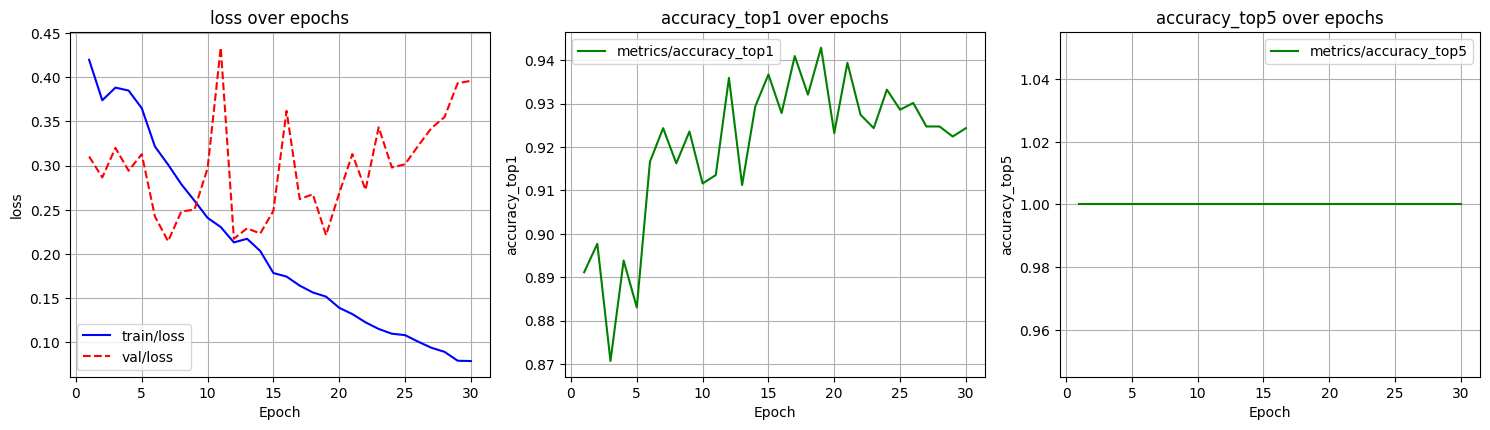

In [16]:
import math
import matplotlib.pyplot as plt

train_metrics = [col for col in df.columns if col.startswith('train/')]
val_metrics = [col.replace('train/', 'val/') for col in train_metrics if col.replace('train/', 'val/') in df.columns]
metric_metrics = [col for col in df.columns if col.startswith('metrics/')]

n_cols = 3
n_rows = math.ceil(len(train_metrics) / n_cols) + math.ceil(len(metric_metrics) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, train_metric in enumerate(train_metrics):
    val_metric = train_metric.replace('train/', 'val/')
    
    axes[i].plot(df['epoch'], df[train_metric], linestyle='-', label=f'{train_metric}', color='blue')
    axes[i].plot(df['epoch'], df[val_metric], linestyle='--', label=f'{val_metric}', color='red')
    
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel(train_metric.split('/')[-1])
    axes[i].set_title(f'{train_metric.split("/")[-1]} over epochs')
    axes[i].legend()
    axes[i].grid(True)

# Рисуем метрики metrics/
for j, metric in enumerate(metric_metrics, start=len(train_metrics)):
    axes[j].plot(df['epoch'], df[metric], linestyle='-', label=metric, color='green')
    
    axes[j].set_xlabel('Epoch')
    axes[j].set_ylabel(metric.split('/')[-1])
    axes[j].set_title(f'{metric.split("/")[-1]} over epochs')
    axes[j].legend()
    axes[j].grid(True)

# Удаление лишних подграфиков
for i in range(len(train_metrics) + len(metric_metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(f"grafics_{today}.png", dpi=300) 
plt.show()